Subajuste y sobreajuste --- 0:00 min
===

* Última modificación: Marzo 7, 2022 | YouTube

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Dataset
--

In [2]:
#
# Descarga el archivo en formato csv.gz (comprimido)
#
# El dataset original contiene 11.000.000 de ejemplos
# y 28 variables independientes. La variable dependiente
# es binaria.
#
# Para este ejemplo, y tal como se hace en el tutorial
# original de TensorFlow se usaran 11.000 ejemplos. Ya
# que el tiempo de descarga es largo debido al tamaño
# del archivo original, se creo un archivo que contiene
# unicamente los ejemplos usados en esta lección.
#
!wget -O /tmp/HIGGS-tiny.csv.gz https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/HIGGS-tiny.csv.gz

In [4]:
FEATURES = 28

In [6]:
ds = tf.data.experimental.CsvDataset(
    "/tmp/HIGGS-tiny.csv.gz",
    [
        float(),
    ]
    * (FEATURES + 1),
    compression_type="GZIP",
)

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(
        row[1:],
        1,
    )
    return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


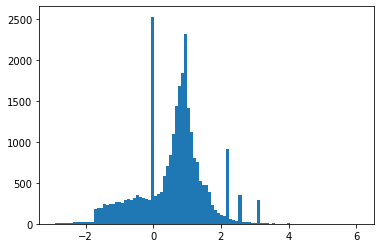

In [10]:
import matplotlib.pyplot as plt

for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(
        features.numpy().flatten(),
        bins=101,
    )

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

Demostración del sobreajuste
--

**Entrenamiento**

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH * 1000,
    decay_rate=1,
    staircase=False,
)


def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

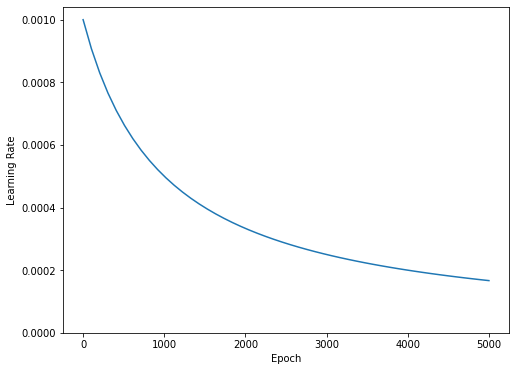

In [18]:
import numpy as np

step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

In [20]:
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp()) / "tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
logdir

PosixPath('/tmp/tmpobkdjnq7/tensorboard_logs')

In [37]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy",
            patience=200,
        ),
        tf.keras.callbacks.TensorBoard(logdir / name),
    ]

In [38]:
def compile_and_fit(
    model,
    name,
    optimizer=None,
    max_epochs=10000,
):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.losses.BinaryCrossentropy(
                from_logits=True, name="binary_crossentropy"
            ),
            "accuracy",
        ],
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0,
    )
    return history

**Modelo diminuto**

In [39]:
tiny_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            16,
            activation="elu",
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(1),
    ]
)

In [40]:
size_histories = {}

In [41]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16)                464       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4919,  binary_crossentropy:0.7917,  loss:0.7917,  val_accuracy:0.4920,  val_binary_crossentropy:0.7699,  val_loss:0.7699,  
....................................................................................................
Epoch: 100, accuracy:0.5918,  binary_crossentropy:0.6294,  loss:0.6294,  val_accuracy:0.5720,  val_binary_crossentropy:0.6282,  val_loss:0.6282,  
..........................................................

(0.5, 0.7)

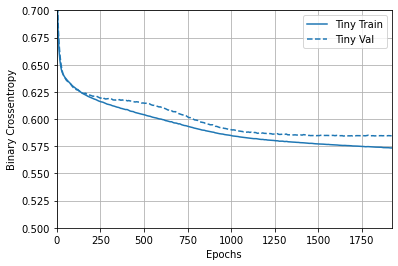

In [45]:
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter(
    metric="binary_crossentropy",
    smoothing_std=10,
)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

**Modelo pequeño**

In [46]:
small_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)

In [47]:
size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                464       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4834,  binary_crossentropy:0.7778,  loss:0.7778,  val_accuracy:0.4330,  val_binary_crossentropy:0.7669,  val_loss:0.7669,  
....................................................................................................
Epoch: 100, accuracy:0.6182,  binary_crossentropy:0.6155,  loss:0.6155,  

KeyboardInterrupt: 

**Modelo medio**

In [ ]:
medium_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)

In [ ]:
size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

**Modelo grande**

In [ ]:
large_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(512, activation="elu"),
        tf.keras.layers.Dense(512, activation="elu"),
        tf.keras.layers.Dense(512, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

**Graficación de las pérdidas para los datasets de entrenamiento y validación**

In [ ]:
plotter.plot(size_histories)
a = plt.xscale("log")
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

**Visualización en TensorBoard**

```python
#
# Carga la extensión de TensorBoard
#
%load_ext tensorboard
```

```python
#
# Carga TensorBoard al notebook
#
%tensorboard --host=0.0.0.0 --logdir {LOGDIR}
```

![assets/tensorboard-gui.png](assets/tensorboard-gui.png)

```shell
$ tensorboard dev upload --logdir  {logdir}/sizes
````


Estrategias para prevenir sobreajuste
--

In [ ]:
shutil.rmtree(logdir / "regularizers/Tiny", ignore_errors=True)
shutil.copytree(logdir / "sizes/Tiny", logdir / "regularizers/Tiny")

In [ ]:
regularizer_histories = {}
regularizer_histories["Tiny"] = size_histories["Tiny"]

**Adición de un término de regularización**

In [ ]:
l2_model = tf.keras.Sequential(
    [
        layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=regularizers.l2(0.001),
            input_shape=(FEATURES,),
        ),
        layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=regularizers.l2(0.001),
        ),
        layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=regularizers.l2(0.001),
        ),
        layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=regularizers.l2(0.001),
        ),
        layers.Dense(1),
    ]
)

regularizer_histories["l2"] = compile_and_fit(
    l2_model,
    "regularizers/l2",
)

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

**Dropout**

In [ ]:
dropout_model = tf.keras.Sequential(
    [
        layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(1),
    ]
)

regularizer_histories["dropout"] = compile_and_fit(
    dropout_model, "regularizers/dropout"
)

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

**Combinación de regularización + Dropout**

In [ ]:
combined_model = tf.keras.Sequential(
    [
        layers.Dense(
            512,
            kernel_regularizer=regularizers.l2(0.0001),
            activation="elu",
            input_shape=(FEATURES,),
        ),
        layers.Dropout(0.5),
        layers.Dense(
            512,
            kernel_regularizer=regularizers.l2(0.0001),
            activation="elu",
        ),
        layers.Dropout(0.5),
        layers.Dense(
            512,
            kernel_regularizer=regularizers.l2(0.0001),
            activation="elu",
        ),
        layers.Dropout(0.5),
        layers.Dense(
            512,
            kernel_regularizer=regularizers.l2(0.0001),
            activation="elu",
        ),
        layers.Dropout(0.5),
        layers.Dense(1),
    ]
)

regularizer_histories["combined"] = compile_and_fit(
    combined_model, "regularizers/combined"
)

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

**Visualización en TensorBoard**

```python
%tensorboard --logdir {logdir}/regularizers
````


```shell
$ tensorboard dev upload --logdir  {logdir}/regularizers
```

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width="100%",
    height="800px",
)

![assets/overfit-underfit.png](assets/overfit-underfit.png)